In [15]:
import json
import sys

sys.path.append("/workspace/circuit-finder")
from circuit_finder.patching.eap_graph import EAPGraph
from circuit_finder.constants import ProjectDir
from circuit_finder.plotting import show_attrib_graph

results_dir = ProjectDir / "results" / "leap_experiment" / "batch_0"
print(results_dir)
assert results_dir.exists()

/home/daniel/ml_workspace/circuit-finder/results/leap_experiment/batch_0


# Print Hparams

In [16]:
config = json.load(open(results_dir / "config.json"))
for key, value in config.items():
    print(f"{key}: {value}")

dataset_path: datasets/ioi/ioi_vanilla_template_prompts.json
save_dir: results/leap_experiment
seed: 1
batch_size: 1
total_dataset_size: 1
ablate_nodes: bm
ablate_errors: False
ablate_tokens: corrupt
first_ablate_layer: 2
verbose: False


# Show Dataset

In [17]:
import pandas as pd
pd.set_option('display.max_colwidth', None)

dataset = results_dir / "dataset.json"
with open(dataset, 'r') as f:
    dataset = json.load(f)

df = pd.DataFrame(dataset)
df.head()

,clean,answer,wrong_answer,corrupt
0,"<|endoftext|>When Ruby and Charlie went to the house, Charlie gave a snack to",Ruby,Charlie,"<|endoftext|>When Eva and Anna went to the house, Connor gave a snack to"


# Plot Graph

Threshold: 0.001, n_edges: 15220
Threshold: 0.006, n_edges: 647


Threshold: 0.01, n_edges: 202


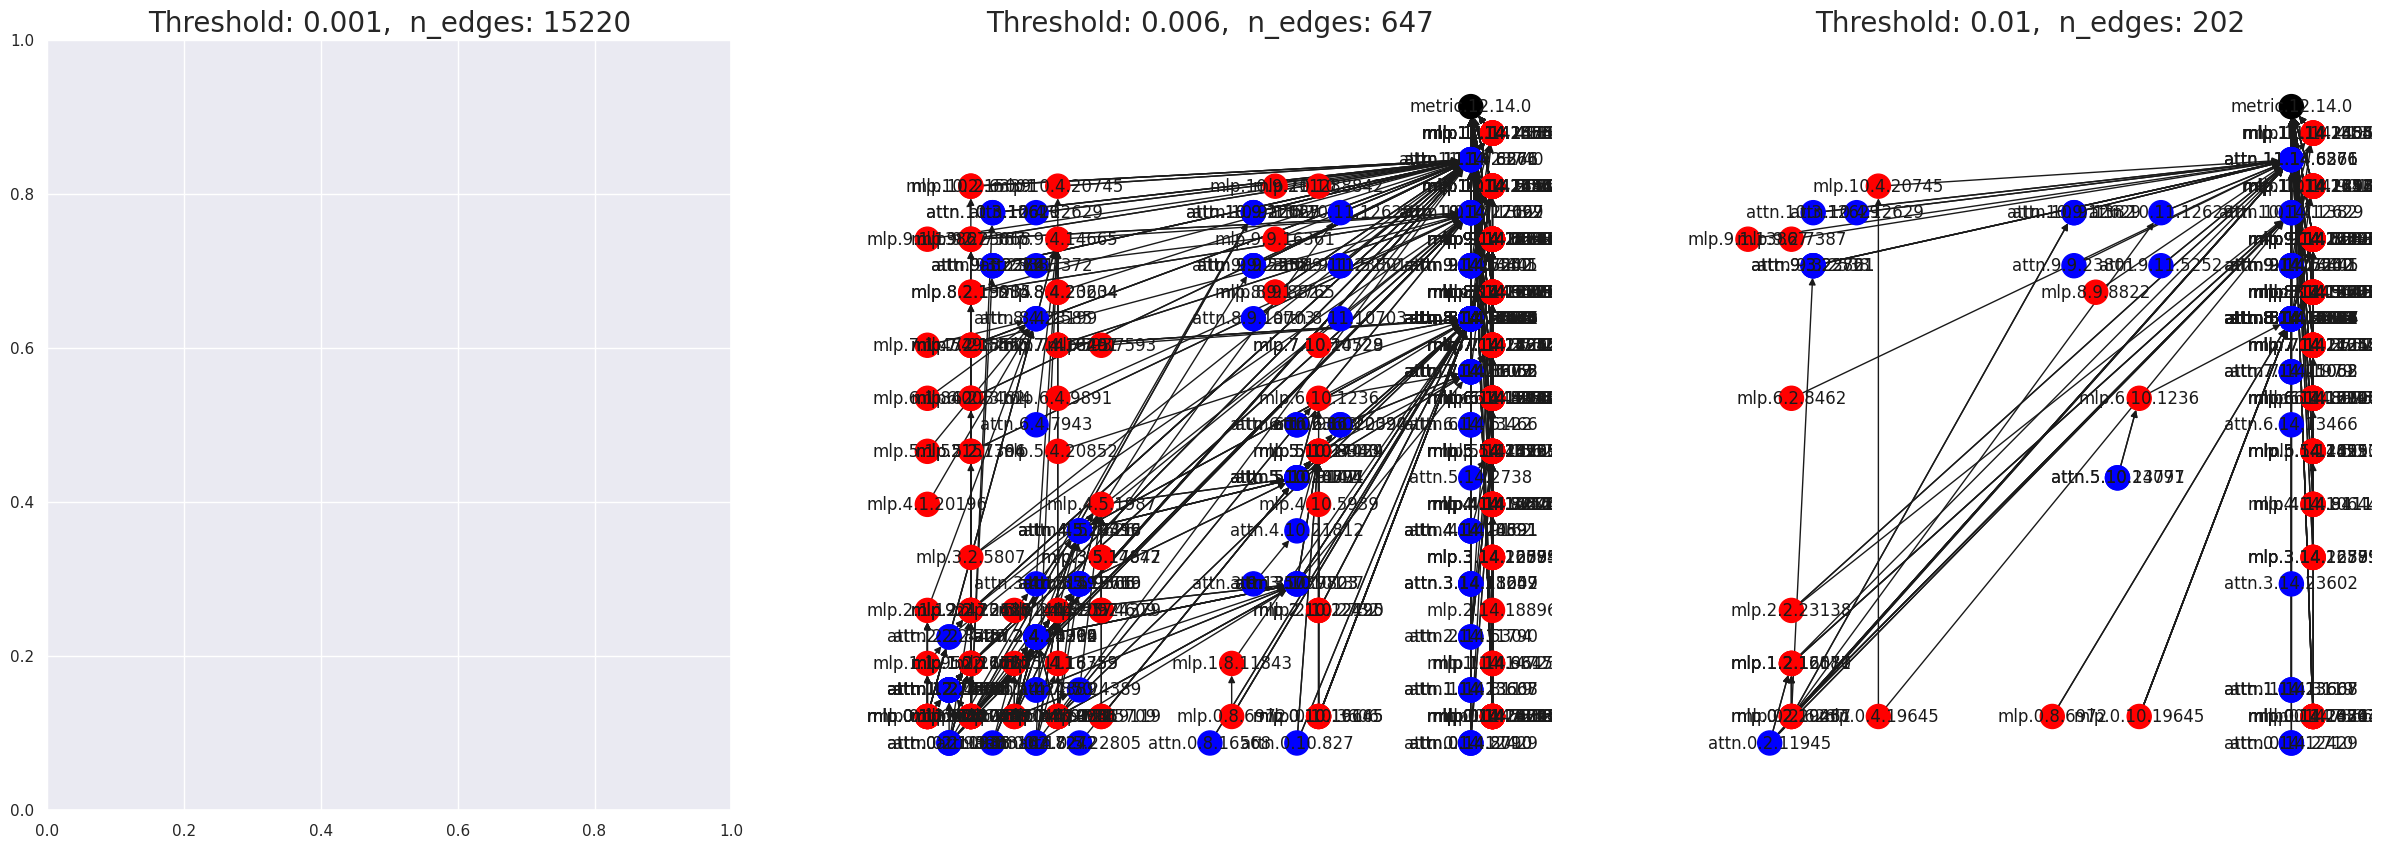

In [18]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(30, 10))
thresholds = [
    0.001,
    # 0.003,
    0.006,
    0.01,
]

for ax, threshold in zip(axs, thresholds):
    with open(results_dir / f"leap-graph_threshold={threshold}.json") as f:
        graph = EAPGraph.from_json(json.load(f))

    n_edges = len(graph.get_edges())
    print(f"Threshold: {threshold}, n_edges: {n_edges}")
    ax.set_title(f"Threshold: {threshold},  n_edges: {n_edges}", fontsize=20)

    if n_edges > 1000:
        continue
    show_attrib_graph(graph, ax=ax)


fig.show()

## Inspect the graph

In [19]:
threshold = 0.01
with open(results_dir / f"leap-graph_threshold={threshold}.json") as f:
    graph = EAPGraph.from_json(json.load(f))


In [20]:
## Print the distribution of nodes
import pandas as pd
from circuit_finder.core.types import parse_node_name

rows = []
for edge, edge_info, _ in graph.graph:
    dest, src = edge
    if 'metric' in src: continue
    nn_grad, nn_attrib, em_grad, em_attrib = edge_info 
    src_module_type, src_layer, src_token, src_feature = parse_node_name(src)
    dest_module_type, dest_layer, dest_token, dest_feature = parse_node_name(dest)
    rows.append({
        "src_module_type": src_module_type,
        "dest_module_type": dest_module_type,
        "src_layer": src_layer,
        "dest_layer": dest_layer,
        "src_token": src_token,
        "dest_token": dest_token,
        "src_feature": src_feature,
        "dest_feature": dest_feature,
        "nn_grad": nn_grad,
        "nn_attrib": nn_attrib,
        "em_grad": em_grad,
        "em_attrib": em_attrib,
    })
df = pd.DataFrame(rows)
print(len(df))
df.head()

187


,src_module_type,dest_module_type,src_layer,dest_layer,src_token,dest_token,src_feature,dest_feature,nn_grad,nn_attrib,em_grad,em_attrib
0,mlp,metric,0,12,14,14,630,0,0.013938,0.098752,0.013938,0.098752
1,mlp,metric,0,12,14,14,7866,0,0.010113,0.045852,0.010113,0.045852
2,mlp,metric,0,12,14,14,19861,0,0.019288,0.025789,0.019288,0.025789
3,mlp,metric,0,12,14,14,23747,0,0.025901,0.013500,0.025901,0.013500
4,mlp,metric,0,12,14,14,24214,0,0.013382,0.012029,0.013382,0.012029


Index(['src_layer', 'src_module_type', 'dest_module_type', 'dest_layer',
       'src_token', 'dest_token', 'src_feature', 'dest_feature', 'nn_grad',
       'nn_attrib', 'em_grad', 'em_attrib'],
      dtype='object')


Text(0.5, 1.0, 'Total edge attribution by src layer')

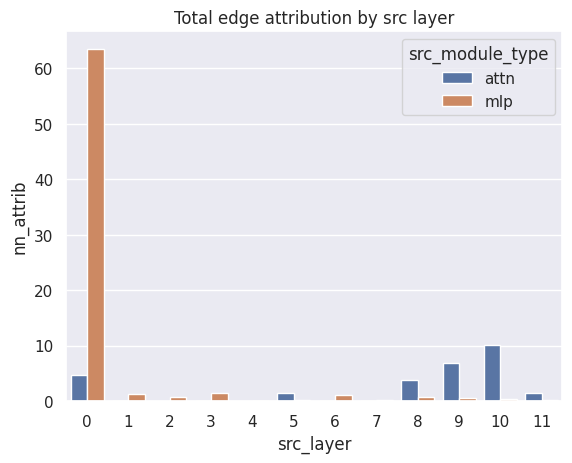

In [21]:
import seaborn as sns
import matplotlib.pyplot as plt

total_attrib_df = df.groupby(["src_layer", "src_module_type"]).sum().reset_index()
print(total_attrib_df.columns)
# Plot the total edge attribution by src layer
sns.barplot(x="src_layer", y="nn_attrib", data=total_attrib_df, hue="src_module_type")
plt.title("Total edge attribution by src layer")

Text(0.5, 1.0, 'Number of nodes in each layer')

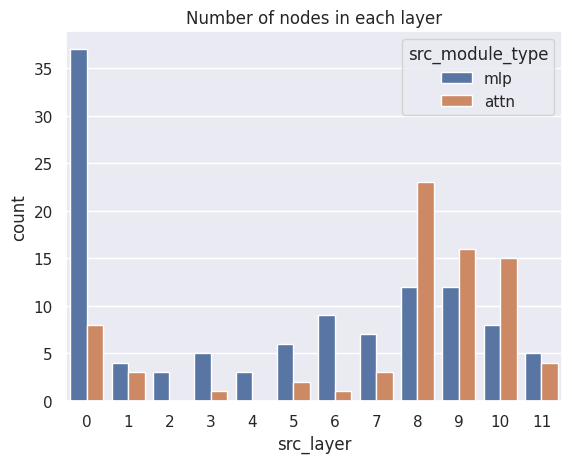

In [22]:
# Plot the number of nodes in each layer
sns.countplot(x="src_layer", data=df, hue="src_module_type")
plt.title("Number of nodes in each layer")

In [23]:
## Highest nodes by NN attrib

df.sort_values(by='em_attrib', ascending=False).head(10)

,src_module_type,dest_module_type,src_layer,dest_layer,src_token,dest_token,src_feature,dest_feature,nn_grad,nn_attrib,em_grad,em_attrib
91,attn,metric,10,12,14,14,12629,0,0.123549,2.048094,0.123549,2.048094
87,attn,metric,9,12,14,14,5252,0,0.133909,1.609423,0.133909,1.609423
94,attn,metric,11,12,14,14,8876,0,0.071134,0.733297,0.071134,0.733297
77,attn,metric,8,12,14,14,10703,0,0.071219,0.367900,0.071219,0.367900
99,mlp,attn,0,11,2,14,6287,8876,0.197629,4.022268,0.014058,0.286119
139,mlp,attn,0,10,2,14,6287,12629,0.300974,6.125616,0.013374,0.272196
105,mlp,attn,0,11,2,14,6287,6261,0.161654,3.290085,0.009409,0.191501
92,attn,metric,11,12,14,14,6261,0,0.058206,0.125246,0.058206,0.125246
0,mlp,metric,0,12,14,14,630,0,0.013938,0.098752,0.013938,0.098752
141,mlp,attn,0,10,2,14,20261,12629,0.171943,1.805923,0.007640,0.080248


### Layer 9 Attention SAE Features

In [24]:
from circuit_finder.neuronpedia import get_neuronpedia_url_for_quick_list

layer = 9

features = df[
    (df.src_layer == layer) & 
    (df.src_module_type == 'attn')
]['src_feature'].unique()

print(get_neuronpedia_url_for_quick_list(layer, features, "att-kk"))

https://neuronpedia.org/quick-list/?name=temporary_list&features=%5B%7B%22modelId%22%3A%20%22gpt2-small%22%2C%20%22layer%22%3A%20%229-att-kk%22%2C%20%22index%22%3A%20%225252%22%7D%2C%20%7B%22modelId%22%3A%20%22gpt2-small%22%2C%20%22layer%22%3A%20%229-att-kk%22%2C%20%22index%22%3A%20%225500%22%7D%2C%20%7B%22modelId%22%3A%20%22gpt2-small%22%2C%20%22layer%22%3A%20%229-att-kk%22%2C%20%22index%22%3A%20%227242%22%7D%2C%20%7B%22modelId%22%3A%20%22gpt2-small%22%2C%20%22layer%22%3A%20%229-att-kk%22%2C%20%22index%22%3A%20%2214445%22%7D%2C%20%7B%22modelId%22%3A%20%22gpt2-small%22%2C%20%22layer%22%3A%20%229-att-kk%22%2C%20%22index%22%3A%20%222538%22%7D%2C%20%7B%22modelId%22%3A%20%22gpt2-small%22%2C%20%22layer%22%3A%20%229-att-kk%22%2C%20%22index%22%3A%20%2223861%22%7D%2C%20%7B%22modelId%22%3A%20%22gpt2-small%22%2C%20%22layer%22%3A%20%229-att-kk%22%2C%20%22index%22%3A%20%2222721%22%7D%2C%20%7B%22modelId%22%3A%20%22gpt2-small%22%2C%20%22layer%22%3A%20%229-att-kk%22%2C%20%22index%22%3A%20%2223801%22%

In [25]:
layer = 10

features = df[(df.src_layer == layer) & (df.src_module_type == "attn")][
    "src_feature"
].unique()

get_neuronpedia_url_for_quick_list(layer, features, "att-kk")

'https://neuronpedia.org/quick-list/?name=temporary_list&features=%5B%7B%22modelId%22%3A%20%22gpt2-small%22%2C%20%22layer%22%3A%20%2210-att-kk%22%2C%20%22index%22%3A%20%2212629%22%7D%2C%20%7B%22modelId%22%3A%20%22gpt2-small%22%2C%20%22layer%22%3A%20%2210-att-kk%22%2C%20%22index%22%3A%20%221382%22%7D%5D'

In [26]:
layer = 0

features = df[(df.src_layer == layer) & (df.src_module_type == "mlp")][
    "src_feature"
].unique()

print(get_neuronpedia_url_for_quick_list(layer, features, "tres-dc"))

https://neuronpedia.org/quick-list/?name=temporary_list&features=%5B%7B%22modelId%22%3A%20%22gpt2-small%22%2C%20%22layer%22%3A%20%220-tres-dc%22%2C%20%22index%22%3A%20%22630%22%7D%2C%20%7B%22modelId%22%3A%20%22gpt2-small%22%2C%20%22layer%22%3A%20%220-tres-dc%22%2C%20%22index%22%3A%20%227866%22%7D%2C%20%7B%22modelId%22%3A%20%22gpt2-small%22%2C%20%22layer%22%3A%20%220-tres-dc%22%2C%20%22index%22%3A%20%2219861%22%7D%2C%20%7B%22modelId%22%3A%20%22gpt2-small%22%2C%20%22layer%22%3A%20%220-tres-dc%22%2C%20%22index%22%3A%20%2223747%22%7D%2C%20%7B%22modelId%22%3A%20%22gpt2-small%22%2C%20%22layer%22%3A%20%220-tres-dc%22%2C%20%22index%22%3A%20%2224214%22%7D%2C%20%7B%22modelId%22%3A%20%22gpt2-small%22%2C%20%22layer%22%3A%20%220-tres-dc%22%2C%20%22index%22%3A%20%2224393%22%7D%2C%20%7B%22modelId%22%3A%20%22gpt2-small%22%2C%20%22layer%22%3A%20%220-tres-dc%22%2C%20%22index%22%3A%20%226287%22%7D%2C%20%7B%22modelId%22%3A%20%22gpt2-small%22%2C%20%22layer%22%3A%20%220-tres-dc%22%2C%20%22index%22%3A%20%221

# Plot Faithfulness Curve

<Axes: xlabel='num_nodes', ylabel='faithfulness'>

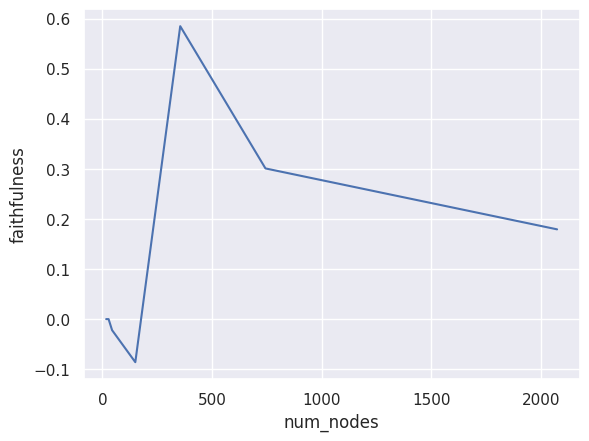

In [27]:
import seaborn as sns
sns.set_theme()

faithfulness_df = pd.read_csv(results_dir / "leap_experiment_results.csv")
sns.lineplot(data=faithfulness_df, x="num_nodes", y="faithfulness")

In [28]:
from circuit_finder.plotting import make_html_graph

make_html_graph(graph)

graph.html
Generated graph.html. Open this file in Live Server to view the graph.
